# Entrega 1 - Predictor de muerte de pacientes con HIV

### Grupo 26:
     - Agustín Martínez  C.I 5.074.743-0
     - Joaquín Mezquita  C.I 5.239.865-9
     - Nicolás Núñez     C.I 5.127.722-0
     



## 1. Objetivo

El objetivo de esta tarea es construir un algortimo capaz de predecir la muerte de pacientes bajo observación por HIV utilizando árboles de decisión generados con el algoritmo ID3 visto en el curso. Para ello, utilizaremos el dataset `AIDS Clinical Trials Group Study 175` tomando como valor a predecir el indicador de censura `cid`. 

El indicador de censura puede tomar dos valores "censoring" o "failure". La censura ocurre cuando un valor de una observación solo se conoce parcialmente. 

En este caso ocurre cuando el experimento termina en un momento determinado, tras el cuál los pacientes todavía vivos quedan todos censurados por la derecha.  

Luego del momento de la última observación no se conocen datos sobre la muerte o supervivencia de los pacientes. Por lo que se puede tomar únicamente el caso "failure" como la muerte de un paciente.d


El éxito del aprendizaje se medirá a traves de las métricas accuracy, precisión, recall y f1, dandole más importancia a la primera y última (podemos tirar algo mas de texto aca)


In [1]:
import funciones
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn.model_selection import KFold

# Objetivo a predecir
OBJETIVO = 'cid'

dataset = pd.read_csv('data.csv')

## Entrenamiento del predictor

Para evaluar la precisión del modelo, el dataset es separado en 3 conjuntos:

- Entrenamiento (70%): Utilizado para entrenar el árbol con el algoritmo ID3
- Validación (15%): Para ajustar los valores de los hiperparametros
- Evaluación (15%): Para probar la precisión del modelo una vez finalizado.

Además, a la hora de separarlos, utilizamos el parametro `stratify=True` de forma que la distribución de la columna `cid` sea similar en los 3 subconjuntos

## Linea base y linea máxima

Podemos trazar como linea base de nuestro predictor un modelo sencillo el cual siempre predice que el resultado será la clase más probable, y como linea máxima, la implementación de random forest utilizada más adelante.

In [2]:
dataset.cid.value_counts()

cid
0    1618
1     521
Name: count, dtype: int64

Vemos que el dataset cuenta con 1618 entradas cuyo resultado es 0 (lo que implica que el paciente no murió durante la observación), y 521 cuyo resultado es 1. 
Tomando esto en cuenta, el predictor simple mencionado anteriormente devolverá que el resultado es siempre 0.
A continuación se muestran los resultados de un modelo con esta característica.

In [3]:
Y_predicho = [0 for _ in range(len(dataset))]
Y_real = dataset[OBJETIVO]

accuracy, precision, recall, f1 = funciones.get_accuracy_precision_recall_f1(Y_real, Y_predicho, objetivo=0)

print('Accuracy de linea base:', accuracy)
print('Precision de linea base:', precision)
print('Recall de linea base:', recall)
print('F1 de linea base:', f1)

Accuracy de linea base: 0.7564282374941561
Precision de linea base: 0.7564282374941561
Recall de linea base: 1.0
F1 de linea base: 0.8613255256853872


Como era de esperar, el accuracy y precisión son equivalentes a la proporción de entradas cuyo resultado es 0 en el dataset.

Por otro lado, y adelantandonos ligeramente sobre los resultados, podemos calcular las mismas métricas sobre la implementación de random forest de la librería scikit-learn, sobre la que entraremos en detalle más adelante.

In [4]:
X_librerias = dataset.copy().drop(columns=[OBJETIVO])
Y_librerias = dataset[OBJETIVO].copy()

X_train_librerias, X_test_librerias, Y_train_librerias, Y_test_librerias = train_test_split(X_librerias, Y_librerias, test_size = 0.2, random_state = 12345, stratify=Y_librerias)

RandomForest = RandomForestClassifier(criterion='entropy', random_state=12345)
RandomForest.fit(X_train_librerias, Y_train_librerias)
Y_predicho_random_forest = RandomForest.predict(X_test_librerias)

accuracy, precision, recall, f1 = funciones.get_accuracy_precision_recall_f1(Y_test_librerias, Y_predicho_random_forest, objetivo=0)

print('Accuracy de linea máxima:', accuracy)
print('Precision de linea máxima:', precision)
print('Recall de linea máxima:', recall)
print('F1 de linea máxima:', f1)

Accuracy de linea máxima: 0.883177570093458
Precision de linea máxima: 0.9005847953216374
Recall de linea máxima: 0.9506172839506173
F1 de linea máxima: 0.924924924924925


Con estas métricas, se espera que el predictor implementado obtenga resultados intermedios entre ambas lineas trazadas.

## 2. Diseño del predictor

## Selección de atributos

Algunos atributos, como puede ser `pidnum` (el número del indice dentro del dataset) pueden ser independientes e irrelevantes para el resultado `cid`, agregando ruido a los datos, y pudiendo llegar a empeorar el modelo a implementar, por lo que, utilizando el método chi-squared, podemos calcular la correlación entre cada atributo y la columna objetivo, de forma de eliminar estos atributos antes de entrenar el arbol. (esto lo podemos poner mas abajo en experimentacón, aunque tecnicamente es parte del preprocesamiento, en experimentacion podemos probar a dropear diferentes combinaciones de los atributos y ver cual da mejor resultado en el set de validación)

In [5]:
pd.options.display.float_format = '{:.12f}'.format

correlacion = []

for x in dataset.columns:
    tabla_contingencia = pd.crosstab(dataset[x], dataset[OBJETIVO])
    _, p, _, _ = chi2_contingency(tabla_contingencia)
    correlacion.append((x, p))

df_correlacion = pd.DataFrame(correlacion, columns=['Atributo', 'p'])

atributos_a_dropear = df_correlacion[df_correlacion['p'] > 0.1]['Atributo'].tolist()

print("Tabla de correlación:")
print(df_correlacion.to_string(index=False))

print(f'\nAtributos a dropear: {atributos_a_dropear}')

Tabla de correlación:
Atributo              p
  pidnum 0.489834014609
     cid 0.000000000000
    time 0.000000000000
     trt 0.000000038716
     age 0.131461430443
    wtkg 0.500435462905
    hemo 0.670749199581
    homo 0.014004920390
   drugs 0.025855212743
  karnof 0.000043533879
  oprior 0.082561827372
     z30 0.000000008761
  zprior 1.000000000000
 preanti 0.006163017165
    race 0.011299936225
  gender 0.043388717863
    str2 0.000000015533
   strat 0.000000008931
 symptom 0.000000003413
   treat 0.000000002960
  offtrt 0.000022164977
    cd40 0.002984809193
   cd420 0.000000059386
    cd80 0.816403752881
   cd820 0.126347769176

Atributos a dropear: ['pidnum', 'age', 'wtkg', 'hemo', 'zprior', 'cd80', 'cd820']


## Discretización del dataset

Antes de entrenar el árbol, se discretizan las variables que tomen valores numéricos continuos, o valores discretos dentro de un intervalo amplio. Es decir, para cada atributo a discretizar, se generan rangos, y cada valor es reemplazado por el índice del rango en el que se encuentra, reduciendo así la cantidad de valores distintos que puede tomar cada atributo.

Para esto, se buscan los mejores puntos de corte que maximicen la ganancia de información. Primero, se calculan todos los posibles puntos de corte para un atributo y se evalúa cual es su ganancia. Luego, se seleccionan los puntos que generan la mejor ganancia de información, respetando el valor de max_range_split. Finalmente, los valores originales del atributo se reemplazan por el índice del rango al que pertenecen, simplificando así el modelo.

Tomando en cuenta las observaciones hechas a las columnas y los valores del dataset, los atributos a discretizar son: 

- pidnum
- time
- age
- wtkg
- karnof
- preanti
- cd40
- cd420
- cd80
- cd820

In [6]:
atributos_a_discretizar = ['pidnum', 'time', 'age', 'wtkg', 'karnof', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820']

## Funciones de selección de atributos

Para evaluar el mejor atributo a seleccionar en cada paso recursivo, se implementan las funciones ''Ganancia'', siendo esta la función básica que busca reducir la incertidumbre al elegir un atributo, ''Gain Ratio'', el cual ajusta la ganancia de información para evitar el sesgo hacia atributos con muchos valores posible, y por último ''Impurity Reduction'', el cual mide que tan ''puro'' es un conjunto de datos (un conjunto es más ''puro'' en caso de contener menos cantidad de valores distintos)

## Preprocesamiento de datos

Por otro lado, dado que el conjunto de datos no contiene atributos con elementos faltantes, no es necesario hacer nada al respecto. Además, el algoritmo utilizado (ID3) no es sensible al orden ni magnitud de los valores, por lo que tampoco es necesario generar un one-hot encoding para atributos categoricos que utilizan valores numéricos para sus etiquetas, como es el caso de "strat", y tampoco es necesario estandarizar los atributos, por la razon mencionada anteriormente.


## Evaluación
- Qué conjunto de métricas se utilizan para la evaluación de la solución y su definición
- Sobre qué conjunto(s) se realiza el entrenamiento, ajuste de la solución, evaluación, etc. Explicar cómo se construyen estos conjuntos.



## 3. Experimentación

A continuación, se muestran los resultados aplicando unicamente discretización del dataset con `max_range_split = 2` y `max_range_split = 3`, y utilizando las 3 funciones de selección de atributos mencionadas.

Notar que el eje y comienza en 0.75 para poder ver mejor la diferencia entre cada función utilizada.

In [7]:
# Esta celda puede tardar en ejecutarse puesto que se tienen que discretizar 2 conjuntos, y entrenar 6 modelos (2 conjuntos y 3 funciones cada una)

X_manual_mrs_2 = funciones.discretizar_atributos(dataset, atributos_a_discretizar, 2).drop(columns=[OBJETIVO])
X_manual_mrs_3 = funciones.discretizar_atributos(dataset, atributos_a_discretizar, 3).drop(columns=[OBJETIVO])
Y_manual = dataset[OBJETIVO].copy()

X_train_mrs_2, X_test_mrs_2, Y_train_mrs_2, Y_test_mrs_2 = train_test_split(X_manual_mrs_2, Y_manual, test_size=0.15, random_state=12345, stratify=Y_manual)
X_train_mrs_2, X_validacion_mrs_2, Y_train_mrs_2, Y_validacion_mrs_2 = train_test_split(X_train_mrs_2, Y_train_mrs_2, test_size=0.15, random_state=12345, stratify=Y_train_mrs_2)

X_train_mrs_3, X_test_mrs_3, Y_train_mrs_3, Y_test_mrs_3 = train_test_split(X_manual_mrs_3, Y_manual, test_size=0.15, random_state=12345, stratify=Y_manual)
X_train_mrs_3, X_validacion_mrs_3, Y_train_mrs_3, Y_validacion_mrs_3 = train_test_split(X_train_mrs_3, Y_train_mrs_3, test_size=0.15, random_state=12345, stratify=Y_train_mrs_3)

resultados_max_range_split_2 = funciones.entrenar_y_evaluar(X_train_mrs_2, Y_train_mrs_2, X_validacion_mrs_2, Y_validacion_mrs_2)
resultados_max_range_split_3 = funciones.entrenar_y_evaluar(X_train_mrs_3, Y_train_mrs_3, X_validacion_mrs_3, Y_validacion_mrs_3)

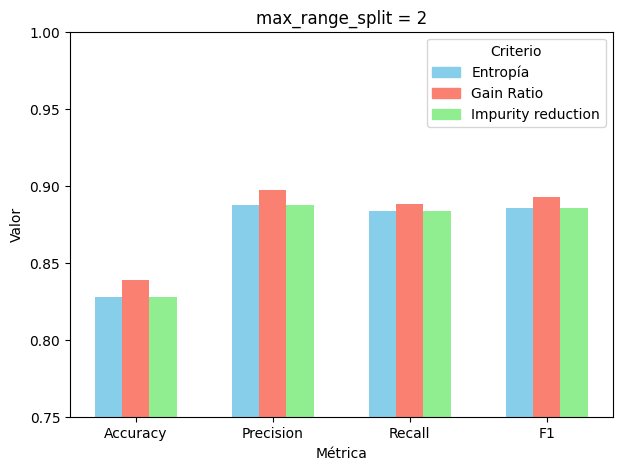

Resultados para max_range_split = 2:
Accuracy:
  Entropia: 0.8278388278388278
  Gain ratio: 0.8388278388278388
  Impurity reduction: 0.8278388278388278

Precision:
  Entropia: 0.8878048780487805
  Gain ratio: 0.8970588235294118
  Impurity reduction: 0.8878048780487805

Recall:
  Entropia: 0.883495145631068
  Gain ratio: 0.8883495145631068
  Impurity reduction: 0.883495145631068

F1:
  Entropia: 0.8856447688564477
  Gain ratio: 0.8926829268292683
  Impurity reduction: 0.8856447688564477



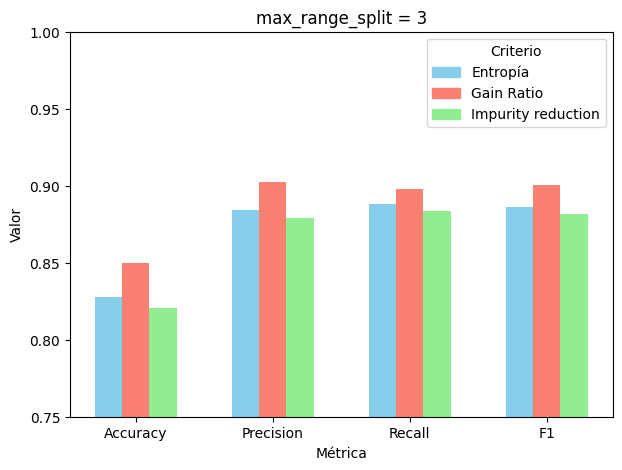

Resultados para max_range_split = 3:
Accuracy:
  Entropia: 0.8278388278388278
  Gain ratio: 0.8498168498168498
  Impurity reduction: 0.8205128205128205

Precision:
  Entropia: 0.8840579710144928
  Gain ratio: 0.9024390243902439
  Impurity reduction: 0.8792270531400966

Recall:
  Entropia: 0.8883495145631068
  Gain ratio: 0.8980582524271845
  Impurity reduction: 0.883495145631068

F1:
  Entropia: 0.8861985472154964
  Gain ratio: 0.9002433090024331
  Impurity reduction: 0.8813559322033898



In [16]:
metricas = ['Accuracy', 'Precision', 'Recall', 'F1']

funciones.plot_metrics(resultados_max_range_split_2, 2)

print('Resultados para max_range_split = 2:')
for i, metrica in enumerate(metricas):
    print(f'{metrica}:')
    for key, value in resultados_max_range_split_2.items():
        print(f'  {key}: {value[i]}')
    print("")  

funciones.plot_metrics(resultados_max_range_split_3, 3)

print('Resultados para max_range_split = 3:')
for i, metrica in enumerate(metricas):
    print(f'{metrica}:')
    for key, value in resultados_max_range_split_3.items():
        print(f'  {key}: {value[i]}')
    print("") 

Se observa como la función que utiliza `gain ratio` es superior en todos los casos. Además, también vemos como se obtienen mejores resultados al utiliza `max_range_split = 3` por sobre `max_range_split = 2`.

A continuación se muestran los resultados en caso de eliminar los atributos dichos anteriormente, es decir, aquellos con una correlación muy poco significativa con el atributo objetivo.
En este caso, se compararán los resultados con los obtenidos anteriormente unicamente sobre la función que utiliza gain ratio, al ver que esta fue la que mejor resultado dió.

In [9]:
# Esta celda puede tardar en ejecutarse puesto que se tienen que discretizar 2 conjuntos, y entrenar 6 modelos (2 conjuntos y 3 funciones cada una)
X_train_mrs_2 = X_train_mrs_2.drop(columns=atributos_a_dropear)
X_train_mrs_3 = X_train_mrs_3.drop(columns=atributos_a_dropear)

resultados_max_range_split_2_atributos_dropeados = funciones.entrenar_y_evaluar(X_train_mrs_2, Y_train_mrs_2, X_validacion_mrs_2, Y_validacion_mrs_2)
resultados_max_range_split_3_atributos_dropeados = funciones.entrenar_y_evaluar(X_train_mrs_3, Y_train_mrs_3, X_validacion_mrs_3, Y_validacion_mrs_3)

Resultados para max_range_split = 2:


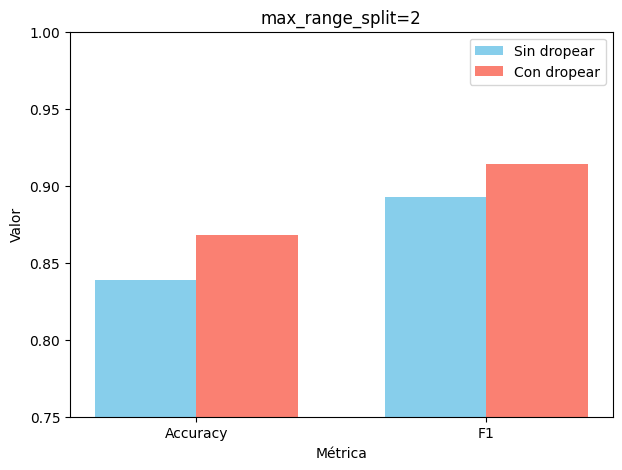

Accuracy sin dropear: 0.8388278388278388 | Accuracy con dropear: 0.8681318681318682
F1 sin dropear: 0.8926829268292683 | F1 con dropear: 0.9138755980861244



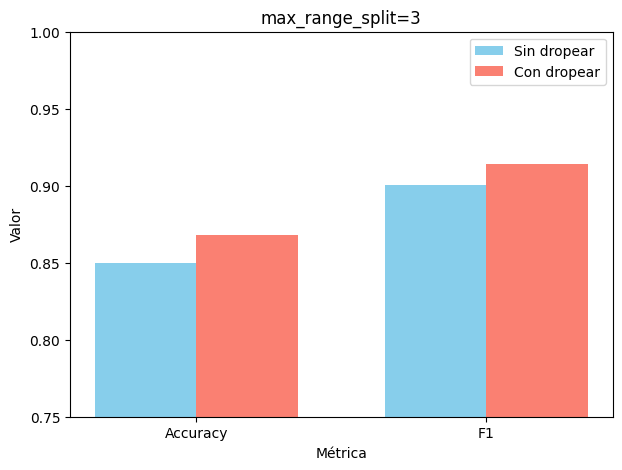

Accuracy sin dropear: 0.8498168498168498 | Accuracy con dropear: 0.8681318681318682
F1 sin dropear: 0.9002433090024331 | F1 con dropear: 0.9138755980861244



In [10]:
print('Resultados para max_range_split = 2:')

resultados_sin_dropear = resultados_max_range_split_2['Gain ratio']
resultados_con_dropear = resultados_max_range_split_2_atributos_dropeados['Gain ratio']
funciones.plot_metrics_comparativa(resultados_sin_dropear, resultados_con_dropear, 2)

print(f'Accuracy sin dropear: {resultados_sin_dropear[0]} | Accuracy con dropear: {resultados_con_dropear[0]}')
print(f'F1 sin dropear: {resultados_sin_dropear[3]} | F1 con dropear: {resultados_con_dropear[3]}')
print("")

resultados_sin_dropear = resultados_max_range_split_3['Gain ratio']
resultados_con_dropear = resultados_max_range_split_3_atributos_dropeados['Gain ratio']
funciones.plot_metrics_comparativa(resultados_sin_dropear, resultados_con_dropear, 3)

print(f'Accuracy sin dropear: {resultados_sin_dropear[0]} | Accuracy con dropear: {resultados_con_dropear[0]}')
print(f'F1 sin dropear: {resultados_sin_dropear[3]} | F1 con dropear: {resultados_con_dropear[3]}')
print("")


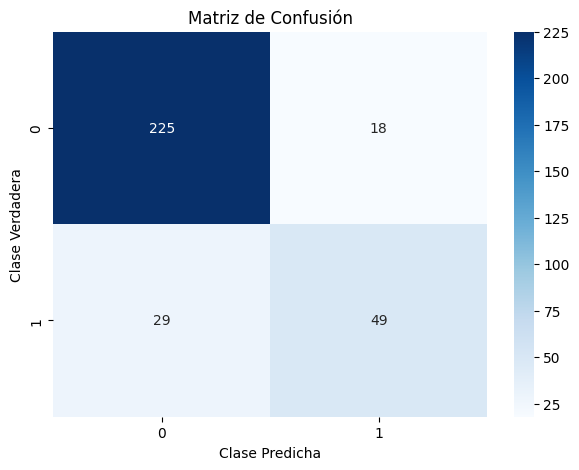

In [14]:
ArbolDecisionManual = funciones.ArbolDecision()
ArbolDecisionManual.entrenar(X_train_mrs_3, Y_train_mrs_3, funciones.get_mejor_atributo_gain_ratio)
Y_predicho_arbol_decision_manual = ArbolDecisionManual.predecir(X_test_mrs_3)
funciones.plot_confusion_matrix(Y_test_mrs_3, Y_predicho_arbol_decision_manual)	


- Debe existir alguna instancia donde se compile la información relevante de los experimentos de forma de poder comparar fácilmente los distintos experimentos. Por ejemplo:

_En la tabla 1, se presentan los distintos resultados contra el jugador aleatorio, para los distintos valores de $\alpha$ elegidos. El mejor resultado se obtiene para $\alpha=0.05$, lo que prueba que la estrategia..._

<table>
  <tr>
    <th>$\alpha$</th>
    <th>...</th>
    <th>Turnos</th>
    <th>Error</th>
  </tr>
  <tr>
    <td>0.001</td>
    <td>...</td>
    <td>100</td>
    <td>0.991</td>
  </tr>    
  <tr>
    <td>0.005</td>
    <td>...</td>
    <td>100</td>
    <td>0.987</td>
  </tr>
  <tr style="font-weight:bold">
    <td>0.05</td>
    <td>...</td>
    <td>100</td>
    <td>0.329</td>
  </tr>
  <tr>
    <td>0.5</td>
    <td>...</td>
    <td>100</td>
    <td>0.564</td>
  </tr>    
    <caption>Tabla 1 - Entrenamiento del jugador X para distintos valores de $\alpha$</caption>
</table>


## 4. Comparación

En esta sección se comparará nuestro algoritmo de ID3 contra los algoritmos de la libreria scikit-learn, además del predictor sencillo mencionado al incio del informe:
- DecisionTreeClassifier
- RandomForestClassifier

Para esto, utilizaremos los hiperparametros que hemos encontrado ser los mejores, es decir, la función gain ratio y los atributos a dropear los anteriormente dichos.

In [11]:
Y_predicho_predictor_simple = [0 for _ in range(len(dataset))]
Y_real = dataset[OBJETIVO]

ArbolDecisionLibreria = DecisionTreeClassifier(criterion='entropy', random_state=12345)
ArbolDecisionLibreria.fit(X_train_librerias, Y_train_librerias)
Y_predicho_arbol_libreria = ArbolDecisionLibreria.predict(X_test_librerias)

RandomForest = RandomForestClassifier(criterion='entropy', random_state=12345)
RandomForest.fit(X_train_librerias, Y_train_librerias)
Y_predicho_random_forest = RandomForest.predict(X_test_librerias)

accuracy_manual, f1_manual = resultados_max_range_split_3['Gain ratio'][0], resultados_max_range_split_3['Gain ratio'][3]
accuracy_arbol_libreria, _, _, f1_arbol_libreria = funciones.get_accuracy_precision_recall_f1(Y_test_librerias, Y_predicho_arbol_libreria)
accuracy_random_forest, _, _, f1_random_forest = funciones.get_accuracy_precision_recall_f1(Y_test_librerias, Y_predicho_random_forest)
accuracy_predictor_simple, _, _, f1_predictor_simple = funciones.get_accuracy_precision_recall_f1(Y_real, Y_predicho_predictor_simple)


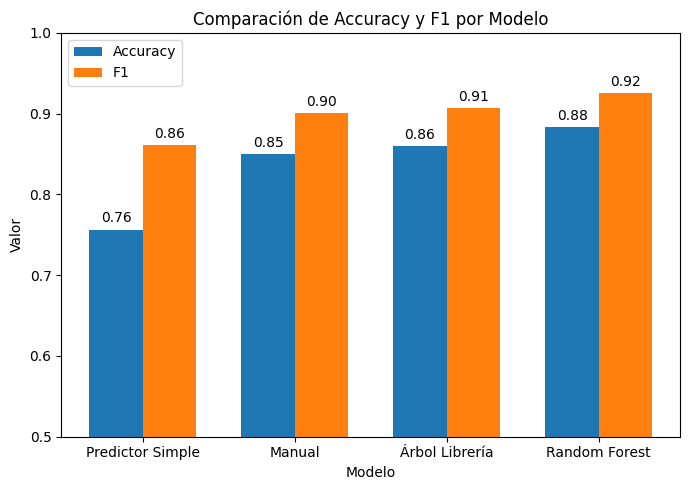

In [12]:
funciones.plot_accuracies_and_f1s([accuracy_predictor_simple, accuracy_manual, accuracy_arbol_libreria, accuracy_random_forest],
                                  [f1_predictor_simple, f1_manual, f1_arbol_libreria, f1_random_forest])

# Aca podemos tirar sobre el intervalo de confianza del predictor 

## 5. Conclusión

Una breve conclusión del trabajo realizado. Por ejemplo: 
- ¿cuándo se dieron los mejores resultados del jugador?
- ¿encuentra alguna relación con los parámetros / oponentes/ atributos elegidos?
- ¿cómo mejoraría los resultados?

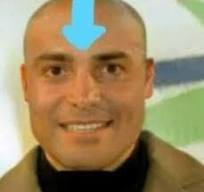